# 1. Data Preprocessing for Federated Learning

**Project:** IoT Network Attack Detection using Federated Learning  
**Dataset:** CICIoT2023 (~12GB, 169 CSV files)  
**Author:** Nguyen Duc Thang

---

## 📋 Objectives

1. Load the CICIoT2023 dataset (169 CSV files) using chunking
2. Clean data (remove nulls, duplicates)
3. Encode 34 attack classes to numeric labels (0-33)
4. Normalize features using MinMaxScaler
5. Partition data for 5 clients (Non-IID distribution)
6. Save preprocessed data for training

---

## 🎯 Expected Outputs

- `../Output/data/client_0_data.npz` ... `client_4_data.npz`
- `../Output/data/test_data.npz`
- `../Output/models/scaler.pkl`
- `../Output/models/label_encoder.pkl`
- `../Output/models/labels.json`

## 1. Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path

# Import our utility modules
from utils import data_utils
from includes import X_columns, y_column, dict_34_classes

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All imports successful!")
print(f"   Number of features: {len(X_columns)}")
print(f"   Label column: {y_column}")
print(f"   Number of attack classes: {len(dict_34_classes)}")

2025-12-28 01:35:36.819267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ All imports successful!
   Number of features: 46
   Label column: label
   Number of attack classes: 34


## 2. Load Configuration

In [3]:
# Load training configuration
config_path = 'configs/training_config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("📄 Configuration loaded:")
print(f"   Number of clients: {config['num_clients']}")
print(f"   Test split ratio: {config['data']['test_split_ratio']}")
print(f"   Chunk size: {config['data']['chunk_size']}")
print(f"   Partition strategy: {config['data']['partition_strategy']}")
print(f"   Use sample data: {config['experimental']['use_sample_data']}")

if config['experimental']['use_sample_data']:
    print(f"   ⚠️  Using {config['experimental']['sample_fraction']*100}% of data for testing")

📄 Configuration loaded:
   Number of clients: 5
   Test split ratio: 0.2
   Chunk size: 50000
   Partition strategy: non_iid
   Use sample data: False


## 3. Load Dataset

This step loads all 169 CSV files using chunking to avoid memory overflow.

In [5]:
# Dataset directory
data_dir = '../DataTests'

# Load dataset with optional sampling
sample_fraction = None
if config['experimental']['use_sample_data']:
    sample_fraction = config['experimental']['sample_fraction']

df = data_utils.load_dataset_chunked(
    data_dir=data_dir,
    chunk_size=config['data']['chunk_size'],
    sample_fraction=sample_fraction
)

print(f"\n✅ Dataset loaded successfully!")
print(f"   Shape: {df.shape}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📂 Loading dataset from: ../DataTests
   Found 11 CSV files
   [1/11] Loading part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 238,687 rows
   [2/11] Loading part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 218,805 rows
   [3/11] Loading part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 275,258 rows
   [4/11] Loading part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 231,023 rows
   [5/11] Loading part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 227,491 rows
   [6/11] Loading part-00005-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 240,046 rows
   [7/11] Loading part-00006-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 233,793 rows
   [8/11] Loading part-00007-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 227,910 rows
   [9/11] Loading part-00008-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 246,327 rows
   [10/11] Loading part-00009-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv... ✓ 227,616 rows
   [11/11]

### 3.1 Explore Dataset

In [6]:
# Display first few rows
print("📊 First 5 rows:")
display(df.head())

# Display data types
print("\n📋 Data types:")
print(df.dtypes.value_counts())

# Display basic statistics
print("\n📈 Basic statistics:")
display(df.describe())

📊 First 5 rows:


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,54.0,54.000000,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,581.33,54.00,66.3,54.796404,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,441.00,42.00,42.0,42.000000,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,525.00,50.00,50.0,50.000000,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.01,0.04,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,644.60,57.88,131.6,67.959230,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood



📋 Data types:
float64    46
object      1
Name: count, dtype: int64

📈 Basic statistics:


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,Telnet,SMTP,SSH,IRC,TCP,UDP,DHCP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
count,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2618348.0,2618348.0,2.618348e+06,2618348.0,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06,2.618348e+06
mean,5.780039e+00,7.744238e+04,9.061689e+00,6.636310e+01,9.061829e+03,9.061829e+03,3.136080e-06,8.650378e-02,2.068052e-01,9.041732e-02,8.795355e-02,1.237509e-01,1.527681e-06,7.638404e-07,9.046397e-02,3.296414e-01,9.890200e-02,6.313676e+00,3.906629e+01,4.838967e-02,5.529632e-02,1.355817e-04,0.0,0.0,4.468466e-05,0.0,5.738271e-01,2.121437e-01,1.527681e-06,6.530835e-05,1.636750e-01,9.998889e-01,9.998889e-01,1.309187e+03,9.163745e+01,1.822877e+02,1.247706e+02,3.343626e+01,1.248081e+02,8.319040e+07,9.498789e+00,1.312466e+01,4.725212e+01,3.102863e+04,9.653754e-02,1.415206e+02
std,2.836095e+02,4.645468e+05,8.933959e+00,1.408785e+01,9.990530e+04,9.990530e+04,1.968057e-03,2.811066e-01,4.050147e-01,2.867788e-01,2.832274e-01,3.292972e-01,1.235993e-03,8.739795e-04,2.863186e-01,6.629534e-01,3.198022e-01,7.280618e+01,3.293117e+02,2.145883e-01,2.285578e-01,1.164317e-02,0.0,0.0,6.684511e-03,0.0,4.945196e-01,4.088261e-01,1.235993e-03,8.081096e-03,3.699804e-01,1.054165e-02,1.054165e-02,2.617463e+03,1.400317e+02,5.265326e+02,2.415562e+02,1.611211e+02,2.423424e+02,1.707611e+07,8.206699e-01,8.635621e+00,2.278813e+02,3.426896e+05,2.331361e-01,2.110573e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,0.000000e+00,4.200000e+01,0.000000e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,2.098472e+00,2.098472e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.250000e+02,5.000000e+01,5.000000e+01,5.000000e+01,0.000000e+00,5.000000e+01,8.307157e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02
50%,0.000000e+00,5.400000e+01,6.000000e+00,6.400000e+01,1.582135e+01,1.582135e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.670000e+02,5.400000e+01,5.400000e+01,5.400000e+01,0.000000e+00,5.400000e+01,8.312452e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02
75%,1.045138e-01,2.976800e+02,1.438000e+01,6.400000e+01,1.178556e+02,1.178556e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00

### 3.2 Check Label Distribution

📊 Label distribution (34 unique labels):
label
DDoS-ICMP_Flood            403793
DDoS-UDP_Flood             303507
DDoS-TCP_Flood             253139
DDoS-PSHACK_Flood          230126
DDoS-SYN_Flood             227796
DDoS-RSTFINFlood           226673
DDoS-SynonymousIP_Flood    201195
DoS-UDP_Flood              186604
DoS-TCP_Flood              149555
DoS-SYN_Flood              112829
BenignTraffic               61851
Mirai-greeth_flood          55187
Mirai-udpplain              50065
Mirai-greip_flood           42144
DDoS-ICMP_Fragmentation     25308
MITM-ArpSpoofing            17258
DDoS-UDP_Fragmentation      16191
DDoS-ACK_Fragmentation      16000
DNS_Spoofing                10142
Recon-HostDiscovery          7492
Recon-OSScan                 5618
Recon-PortScan               4613
DoS-HTTP_Flood               4074
VulnerabilityScan            2091
DDoS-HTTP_Flood              1599
DDoS-SlowLoris               1303
DictionaryBruteForce          729
BrowserHijacking              322
S

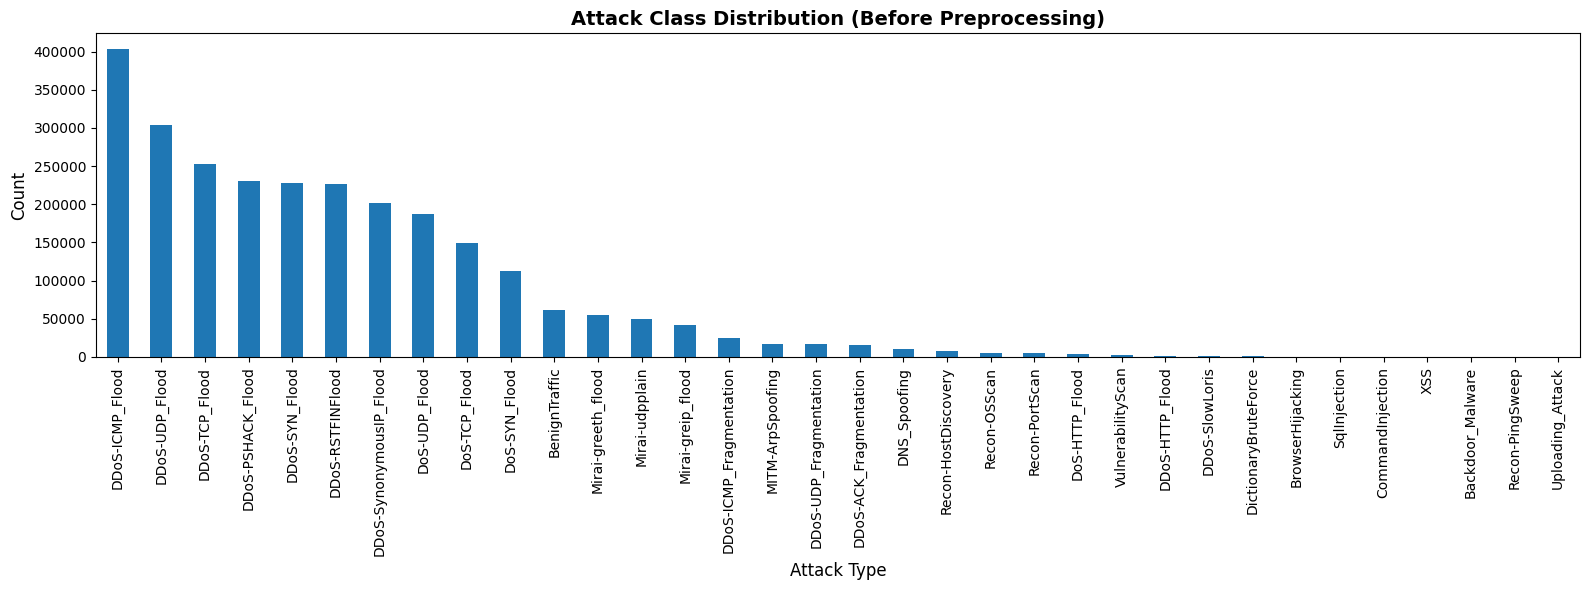


⚖️  Class imbalance ratio: 5047.41x
   ⚠️  Significant class imbalance detected!
   Consider using class weights during training.


In [7]:
# Check label distribution
label_counts = df[y_column].value_counts()

print(f"📊 Label distribution ({len(label_counts)} unique labels):")
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(16, 6))
label_counts.plot(kind='bar')
plt.title('Attack Class Distribution (Before Preprocessing)', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Check for class imbalance
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count
print(f"\n⚖️  Class imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 10:
    print("   ⚠️  Significant class imbalance detected!")
    print("   Consider using class weights during training.")

## 4. Clean Data

Remove missing values and duplicates.

In [8]:
# Clean data
df_clean = data_utils.clean_data(df)

print(f"\n✅ Data cleaned!")
print(f"   Original rows: {len(df):,}")
print(f"   Cleaned rows: {len(df_clean):,}")
print(f"   Rows removed: {len(df) - len(df_clean):,} ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

# Update df
df = df_clean
del df_clean  # Free memory


🧹 Cleaning data...
   ✓ No missing values
   ✓ No duplicates
   Final rows: 2,618,348

✅ Data cleaned!
   Original rows: 2,618,348
   Cleaned rows: 2,618,348
   Rows removed: 0 (0.00%)


## 5. Encode Labels

Convert attack class names to numeric labels (0-33).

In [9]:
# Encode labels
output_models_dir = '../Output/models'
os.makedirs(output_models_dir, exist_ok=True)

df, label_encoder, label_mapping = data_utils.encode_labels(
    df=df,
    label_col=y_column,
    save_path=output_models_dir
)

print(f"\n✅ Labels encoded!")
print(f"\n📋 Label mapping (first 10):")
for i in range(min(10, len(label_mapping))):
    print(f"   {i}: {label_mapping[i]}")
if len(label_mapping) > 10:
    print(f"   ... and {len(label_mapping) - 10} more")


🏷️  Encoding labels...
   Found 34 unique labels:
      DDoS-ICMP_Flood: 403,793 (15.42%)
      DDoS-UDP_Flood: 303,507 (11.59%)
      DDoS-TCP_Flood: 253,139 (9.67%)
      DDoS-PSHACK_Flood: 230,126 (8.79%)
      DDoS-SYN_Flood: 227,796 (8.70%)
      DDoS-RSTFINFlood: 226,673 (8.66%)
      DDoS-SynonymousIP_Flood: 201,195 (7.68%)
      DoS-UDP_Flood: 186,604 (7.13%)
      DoS-TCP_Flood: 149,555 (5.71%)
      DoS-SYN_Flood: 112,829 (4.31%)
      ... and 24 more
   ✓ Encoded 34 classes to numeric values (0-33)
   💾 Saved label encoder to: ../Output/models/label_encoder.pkl
   💾 Saved label mapping to: ../Output/models/labels.json

✅ Labels encoded!

📋 Label mapping (first 10):
   0: Backdoor_Malware
   1: BenignTraffic
   2: BrowserHijacking
   3: CommandInjection
   4: DDoS-ACK_Fragmentation
   5: DDoS-HTTP_Flood
   6: DDoS-ICMP_Flood
   7: DDoS-ICMP_Fragmentation
   8: DDoS-PSHACK_Flood
   9: DDoS-RSTFINFlood
   ... and 24 more


## 6. Normalize Features

Scale all features to [0, 1] range using MinMaxScaler.

In [10]:
# Normalize features
df, scaler = data_utils.normalize_features(
    df=df,
    feature_cols=X_columns,
    save_path=output_models_dir
)

print(f"\n✅ Features normalized!")
print(f"\n📊 Sample normalized values (first 5 rows, first 5 features):")
display(df[X_columns[:5]].head())


📏 Normalizing features...
   ✓ Normalized 46 features to [0, 1] range
   💾 Saved scaler to: ../Output/models/scaler.pkl

✅ Features normalized!

📊 Sample normalized values (first 5 rows, first 5 features):


,flow_duration,Header_Length,Protocol Type,Duration,Rate
0,0.000000,0.000005,0.127660,0.250980,3.931608e-08
1,0.000000,0.000006,0.134681,0.250980,5.114742e-07
2,0.000000,0.000000,0.021277,0.250980,3.981209e-06
3,0.000003,0.007703,0.361702,0.250980,5.533854e-04
4,0.000001,0.000010,0.130000,0.258471,7.393612e-07


## 7. Partition Data for Federated Learning

Split data into:
- 5 client partitions (Non-IID distribution)
- 1 test set (20% of data)

In [11]:
# Partition data
client_data = data_utils.partition_data_noniid(
    df=df,
    num_clients=config['num_clients'],
    label_col=y_column,
    test_split=config['data']['test_split_ratio'],
    random_seed=config['random_seed']
)

print(f"\n✅ Data partitioned!")
print(f"\n📊 Partition summary:")
for client_name, data in client_data.items():
    print(f"   {client_name}: {len(data['X']):,} samples")


🔀 Partitioning data for 5 clients (Non-IID)...
   Train set: 2,094,678 samples
   Test set: 523,670 samples
   Client 0 (DDoS): 781,897 samples
   Client 1 (DoS): 326,468 samples
   Client 2 (Mirai): 65,873 samples
   Client 3 (Recon): 252,418 samples
   Client 4 (Spoofing): 32,232 samples

✅ Data partitioned!

📊 Partition summary:
   client_0: 781,897 samples
   client_1: 326,468 samples
   client_2: 65,873 samples
   client_3: 252,418 samples
   client_4: 32,232 samples
   test: 523,670 samples


### 7.1 Visualize Client Data Distribution

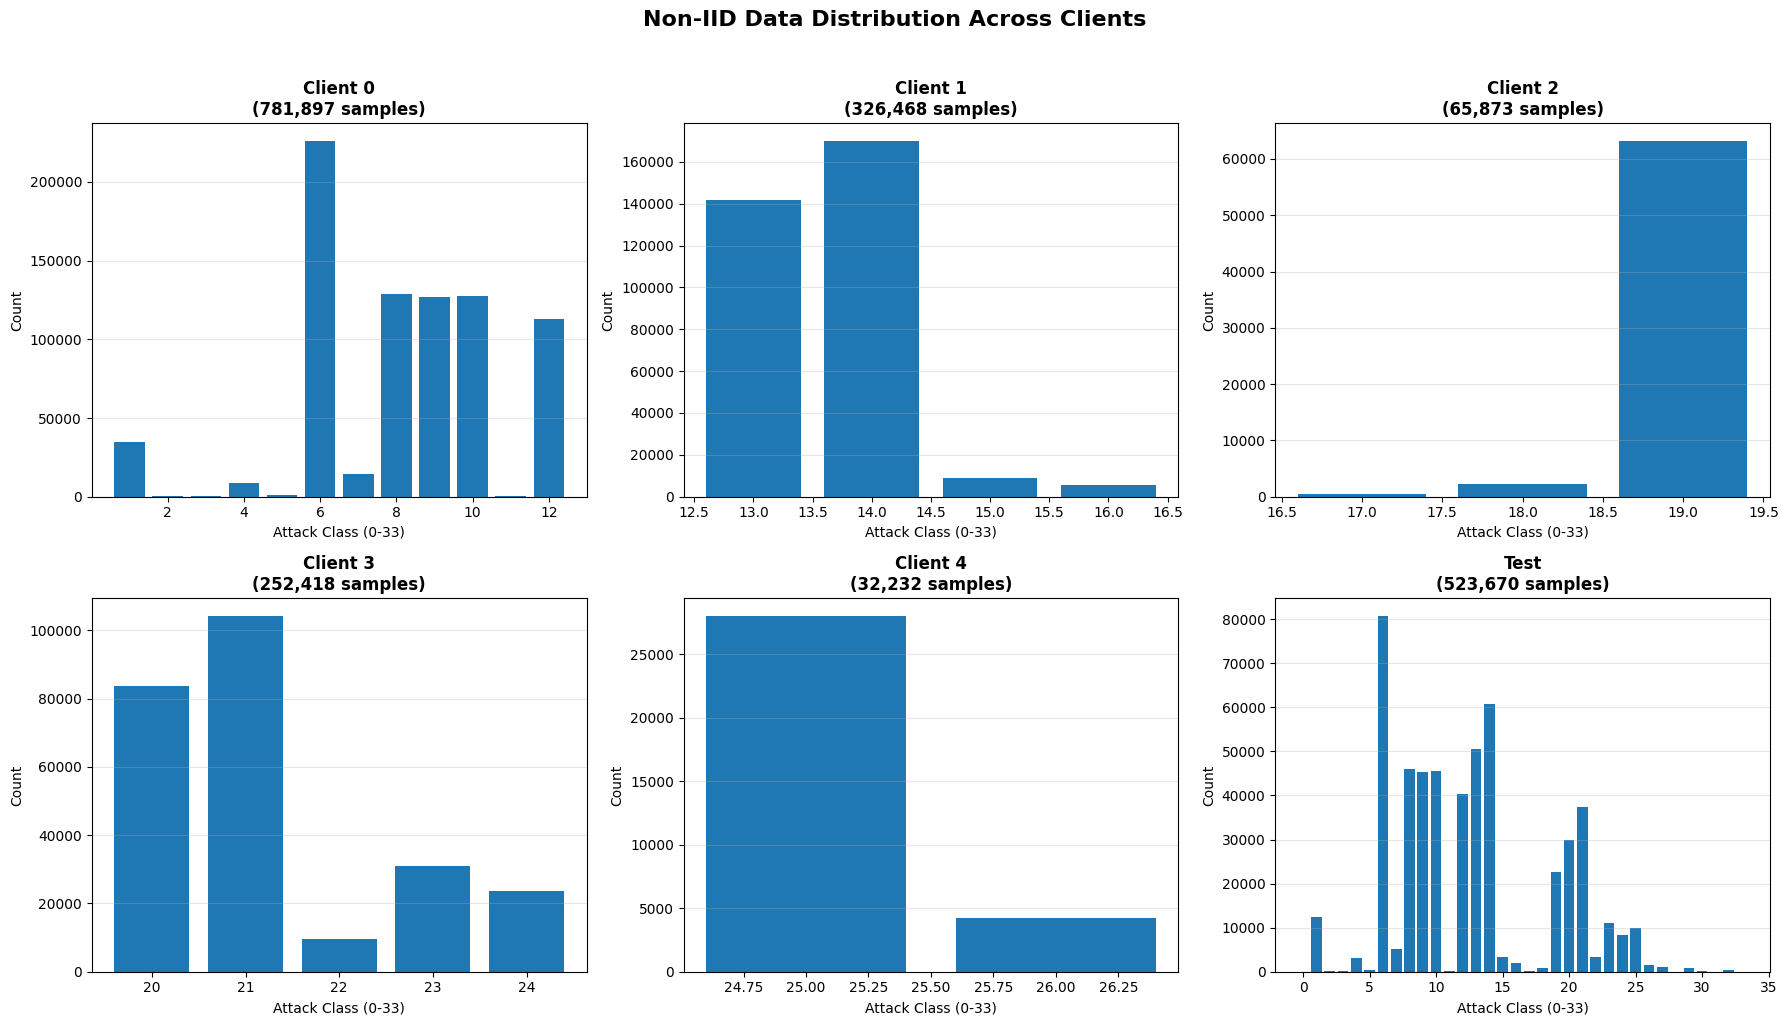


📊 Distribution analysis:
   Each client has a different distribution of attack types (Non-IID)
   This simulates real-world federated learning scenarios.


In [12]:
# Visualize label distribution per client
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (client_name, data) in enumerate(client_data.items()):
    if i >= 6:  # Only plot first 6 (5 clients + test)
        break
    
    # Count labels
    unique, counts = np.unique(data['y'], return_counts=True)
    
    # Plot
    axes[i].bar(unique, counts)
    axes[i].set_title(f'{client_name.replace("_", " ").title()}\n({len(data["X"]):,} samples)', 
                     fontweight='bold')
    axes[i].set_xlabel('Attack Class (0-33)')
    axes[i].set_ylabel('Count')
    axes[i].grid(axis='y', alpha=0.3)

plt.suptitle('Non-IID Data Distribution Across Clients', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Distribution analysis:")
print("   Each client has a different distribution of attack types (Non-IID)")
print("   This simulates real-world federated learning scenarios.")

## 8. Save Partitioned Data

In [13]:
# Save partitioned data
output_data_dir = '../Output/data'

data_utils.save_partitioned_data(
    client_data=client_data,
    save_dir=output_data_dir
)

print(f"\n✅ All data saved successfully!")


💾 Saving partitioned data to: ../Output/data
   ✓ Saved client_0: ../Output/data/client_0_data.npz (781,897 samples)
   ✓ Saved client_1: ../Output/data/client_1_data.npz (326,468 samples)
   ✓ Saved client_2: ../Output/data/client_2_data.npz (65,873 samples)
   ✓ Saved client_3: ../Output/data/client_3_data.npz (252,418 samples)
   ✓ Saved client_4: ../Output/data/client_4_data.npz (32,232 samples)
   ✓ Saved test: ../Output/data/test_data.npz (523,670 samples)
   ✅ All data saved successfully!

✅ All data saved successfully!


## 9. Verification

Verify that all files were created correctly.

In [14]:
# Check saved files
print("🔍 Verifying saved files...\n")

# Check data files
print("📂 Data files:")
for client_name in list(client_data.keys()):
    file_path = os.path.join(output_data_dir, f'{client_name}_data.npz')
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024**2  # MB
        print(f"   ✓ {client_name}_data.npz ({file_size:.2f} MB)")
    else:
        print(f"   ✗ {client_name}_data.npz (NOT FOUND)")

# Check model artifacts
print("\n📂 Model artifacts:")
artifacts = ['scaler.pkl', 'label_encoder.pkl', 'labels.json']
for artifact in artifacts:
    file_path = os.path.join(output_models_dir, artifact)
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"   ✓ {artifact} ({file_size:.2f} KB)")
    else:
        print(f"   ✗ {artifact} (NOT FOUND)")

print("\n✅ Verification complete!")

🔍 Verifying saved files...

📂 Data files:
   ✓ client_0_data.npz (40.51 MB)
   ✓ client_1_data.npz (18.28 MB)
   ✓ client_2_data.npz (4.38 MB)
   ✓ client_3_data.npz (17.51 MB)
   ✓ client_4_data.npz (2.59 MB)
   ✓ test_data.npz (31.55 MB)

📂 Model artifacts:
   ✓ scaler.pkl (2.83 KB)
   ✓ label_encoder.pkl (0.85 KB)
   ✓ labels.json (0.91 KB)

✅ Verification complete!


## 10. Summary

Data preprocessing completed successfully!

In [15]:
print("="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)
print(f"\n📊 Dataset Statistics:")
print(f"   Total samples processed: {sum(len(data['X']) for data in client_data.values()):,}")
print(f"   Number of features: {len(X_columns)}")
print(f"   Number of classes: {len(label_mapping)}")

print(f"\n🔀 Data Partitioning:")
print(f"   Number of clients: {config['num_clients']}")
print(f"   Partition strategy: {config['data']['partition_strategy'].upper()}")
print(f"   Test set size: {len(client_data['test']['X']):,} samples ({config['data']['test_split_ratio']*100}%)")

print(f"\n💾 Output Files:")
print(f"   Data files: {config['num_clients'] + 1} .npz files (5 clients + 1 test)")
print(f"   Model artifacts: 3 files (scaler, encoder, labels)")

print(f"\n✅ Status: READY FOR TRAINING")
print(f"\n📝 Next step: Run 2_Federated_Training.ipynb")
print("="*80)

DATA PREPROCESSING SUMMARY

📊 Dataset Statistics:
   Total samples processed: 1,982,558
   Number of features: 46
   Number of classes: 34

🔀 Data Partitioning:
   Number of clients: 5
   Partition strategy: NON_IID
   Test set size: 523,670 samples (20.0%)

💾 Output Files:
   Data files: 6 .npz files (5 clients + 1 test)
   Model artifacts: 3 files (scaler, encoder, labels)

✅ Status: READY FOR TRAINING

📝 Next step: Run 2_Federated_Training.ipynb
